# !\#$\@: An obscene journey through quotations in media
## ADA: Project Milestone 2
#### Group: k-beans

This notebook contains the initial analysis carried out for our project titled: **"!#$@: An obscene journey through quotations in media"**. 

For that matter, we install the requirements for the project, we load the data and we handle, explore and visualize it in order to understand it better and gain some insights. Specifically, we perform different analysis at quote, speaker and media source level, as they will be very important elements in our study. Moreover, the profanity score - which is the essence and main motivation for this project - is computed for all quotes considered and its presence in the dataset is analyzed as well, regarding different aspects. Time will also be considered as a relevant factor for the study. Finally, a small sentiment analysis experiment will be carried out so that we can present a clear idea of all different methods which are going to be used.

Note: this initial analysis has been executed for 2020 quotebank data only for performance and flexibility aspects, it will be applied to the rest of the data for the next milestone.

## Requirements

In [ ]:
!pip install pyspark==3.1.1 pyarrow tldextract
!pip install alt-profanity-check

Note: you may need to restart the kernel to use updated packages.


## Imports

In [3]:
# Make sure that spark uses the same python distribution to avoid serialization issues due to missing packages
%env PYSPARK_PYTHON=/usr/local/anaconda3/envs/ada/bin/python
%env PYSPARK_DRIVER_PYTHON=/usr/local/anaconda3/envs/ada/bin/python

env: PYSPARK_PYTHON=/usr/local/anaconda3/envs/ada/bin/python
env: PYSPARK_DRIVER_PYTHON=/usr/local/anaconda3/envs/ada/bin/python


In [2]:
import sys
sys.executable

'/usr/local/anaconda3/envs/ada/bin/python'

In [29]:
# Data handling and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# PySpark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType, BooleanType, ArrayType, StringType, DoubleType

# Helpers
import os
import json

# External libraries
import profanity_check
import tldextract
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

## Load Spark

In [5]:
conf = pyspark.SparkConf().setMaster("local[*]").setAll([
    ('spark.driver.memory','8G'),
    ('spark.driver.maxResultSize', '8G'),
    ('spark.sql.execution.arrow.pyspark.enabled', True),
    ('spark.sql.execution.arrow.maxRecordsPerBatch', 10000),
    ('spark.local.dir', '/tmp')
])

spark = SparkSession.builder.config(conf=conf).config('spark.jars.packages', 'com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.2').getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')
spark

:: loading settings :: url = jar:file:/usr/local/anaconda3/envs/ada/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/MDS/.ivy2/cache
The jars for the packages stored in: /Users/MDS/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ca5a238b-b5e1-46fa-a818-aca39c110586;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.3.2 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1

## Load data

In [50]:
DATA_DIR    = 'data/'
QB_DATA_DIR = DATA_DIR + 'quotebank_data/'

QB_DATA_JSON_PATH     = QB_DATA_DIR + 'json/quotes-%s.json'
QB_DATA_JSON_BZ2_PATH = QB_DATA_DIR + 'json/quotes-%s.json.bz2'
QB_DATA_PARQUET_PATH  = QB_DATA_DIR + 'parquet/quotes-%s.parquet'
QB_DATA_PROC_PATH     = QB_DATA_DIR + 'processed/quotes-%s.parquet' # contains qb data with profanity scores, tlds, prominent speaker qid, prominent speaker prob, prominent speaker label

SPK_ATTR_PATH             = DATA_DIR + 'speaker_attributes.parquet'
SPK_ATTR_WITH_LABELS_PATH = DATA_DIR + 'speaker_attributes_with_labels.parquet'

LABELS_PATH = DATA_DIR + 'wikidata_labels_descriptions_quotebank.csv.bz2'

YEARS = ['2020']

In [7]:
QB_JSON_SCHEMA = StructType.fromJson(json.loads(
    '''{  "type": "struct", 
        "fields": [
            {"name": "date", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "numOccurrences", "type": "long", "nullable": true,"metadata": {}}, 
            {"name": "phase", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "probas", "type": 
            {"type": "array", "elementType": {"type": "array", "elementType": "string", "containsNull": true}, "containsNull": true}, "nullable": true, "metadata": {}}, 
            {"name": "qids", "type": {"type": "array", "elementType": "string", "containsNull": true}, "nullable": true, "metadata": {}}, 
            {"name": "quotation", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "quoteID", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "speaker", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "urls", "type": {"type": "array", "elementType": "string", "containsNull": true}, "nullable": true, "metadata": {}}
            ]
    }'''))

# Dewmini

### Load the labels of QIDS

In [8]:
labels = pd.read_csv(LABELS_PATH)
labels = labels.set_index("QID")

### Expand speaker attributes with labels

In [9]:
def qids_to_attr_labels(qids):
    if qids is None or len(qids) == 0:
        return []
    return list(map(lambda qid : labels.Label[qid] if qid in labels.index else qid, qids))

def map_missing(iterator):
    for df in iterator:
        for col in ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']:
            df[col + '_labels'] = df[col].apply(qids_to_attrib_labels)
        yield df
        
def expand_spk_attr_with_labels():
    spk_attr = spark.read.parquet(SPK_ATTR_PATH)
    for col in ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']:
        spk_attr = spk_attr.withColumn(col + '_labels', spk_attr[col])
    spk_attr.write.parquet(SPK_ATTR_WITH_LABELS_PATH, 'overwrite')

In [51]:
# Uncomment for the first-run to save the processed files
# expand_spk_attr_with_labels()

In [52]:
# Load expanded data
spk_attr = spark.read.parquet(SPK_ATTR_WITH_LABELS_PATH)

### Expand the quotebank data with top-level-domains, profanity-scores, etc. and save for eaiser loading in the future

In [48]:
def url_list_to_tlds(urls):
    if urls is None or len(urls) == 0:
        return None
    res = list(map(lambda url : tldextract.extract(url).domain, urls))
    return res if res else None

def fill_columns(iterator):
    for df in iterator:
        df['profanity'] = profanity_check.predict_prob(df.quotation)
        df['speaker_qid'] = df['qids'].apply(lambda qids : None if (qids is None or len(qids) == 0) else qids[0])         
        df['speaker_label'] = df['qids'].apply(lambda qids : None if (qids is None or len(qids) == 0) else (labels.Label[qids[0]] if qids[0] in labels.index else None))
        df['tlds'] = df['urls'].apply(url_list_to_tlds)
        df['speaker_prob'] = df['probas'].apply(lambda p : 0.0 if (p is None or len(p) == 0) else float(p[0][1]))
        yield df
        
def prepare_data(df):    
    df = df.withColumn('speaker_qid', f.lit(None).cast(StringType()))
    df = df.withColumn('speaker_label', f.lit(None).cast(StringType()))
    df = df.withColumn('speaker_prob', f.lit(None).cast(DoubleType()))
    df = df.withColumn('tlds', df.urls)
    df = df.withColumn('profanity', f.lit(None).cast(DoubleType()))
    df = df.mapInPandas(fill_columns, schema = df.schema)
    return df

def prepare_data_for_years(years):
    for y in years:
        df = spark.read.json(QB_DATA_JSON_PATH % y, schema=QB_JSON_SCHEMA)
        df = prepare_data(df)
        df.write.parquet(QB_DATA_PROC_PATH % y, 'overwrite')
        

In [49]:
# Uncomment for the first-run to save the processed files
#prepare_data_for_years(YEARS)

In [53]:
qb = spark.read.parquet(QB_DATA_PROC_PATH % YEARS[0])
for y in YEARS[1:]:
    qb = qb.union(spark.read_parquet(QB_DATA_PROC_PATH % y))

# Mauro

In [6]:
# Run it with 2020 data
speaker_attribs = pd.read_parquet(DATA_DIR + 'speaker_attributes.parquet')
speaker_attribs = speaker_attribs.set_index('id')
attrib_labels = pd.read_csv('data/wikidata_labels_descriptions_quotebank.csv.bz2')
attrib_labels = attrib_labels.set_index("QID")

In [3]:
dfs = []
for i in os.listdir(QUOTEBANK_DATA_DIR):
    dfs.append(pd.read_json((QUOTEBANK_DATA_DIR + i), lines=True))
               
df = dfs[0]
if len(dfs) > 1:
    for df_part in dfs[1:]:
        df = df.union(df_part)

In [4]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2019-04-17-024782,"It is not a low-income immigration,",James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E
1,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E
2,2019-05-09-055187,It makes it much more difficult for him to mak...,None,[],2019-05-09 18:11:29,1,"[[None, 0.6493], [President Bill Clinton, 0.27...",[http://mobile.nytimes.com/2019/05/09/world/as...,E
3,2019-10-31-056366,"It puts me in a predicament,",Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E
4,2019-01-04-001792,A Pile of Leaves.,None,[],2019-01-04 10:00:07,1,"[[None, 0.8737], [Jason Fulford, 0.1263]]",[https://www.nytimes.com/2019/01/04/books/revi...,E


## Data Cleaning - Preprocessing (to be extended)

In [5]:
len(df[df.duplicated('quoteID')]) # 0 ~> no duplicate rows

0

## Data Exploration and Visualization

### Exploring Quotes

#### Quotation length distribution

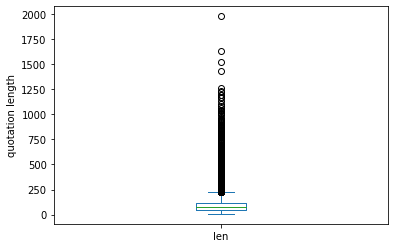

In [18]:
df['len'] = df['quotation'].apply(len) # Add quotation length feature
_ = df['len'].plot(kind='box', ylabel="quotation length", xlabel="quotation length") 

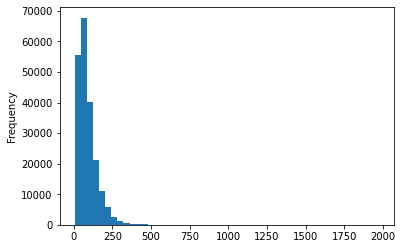

In [19]:
_ = df['len'].plot(kind='hist', bins=50, xlabel="quotation length")

#### Occurrences distribution

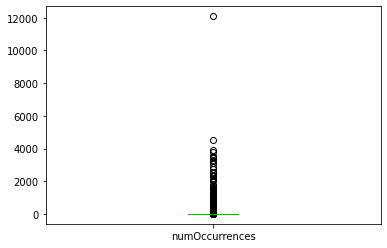

In [20]:
_ = df['numOccurrences'].plot(kind='box')

In [21]:
# Most cited quote
df.loc[df['numOccurrences'].argmax()]

quoteID                                           2019-04-12-080259
quotation                 Star... [ + ] Wars: The Rise of Skywalker
speaker                                                        None
qids                                                             []
date                                            2019-04-12 00:00:00
numOccurrences                                                12095
probas            [[None, 0.4952], [J.J. Abrams, 0.0752], [Daisy...
urls              [http://chronicle.northcoastnow.com/national-n...
phase                                                             E
len                                                              41
Name: 21764, dtype: object

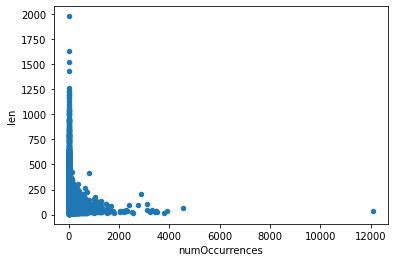

In [22]:
# Visualize plot between quote length and occurrences 
_ = df.plot(kind='scatter', x='numOccurrences', y='len') # Shorter quotes are more cited

### Exploring speakers

#### Speaker frequency

In [7]:
speaker_freq = df['speaker'].value_counts()
speaker_freq.head(15)

None                      75582
President Donald Trump     2217
President Trump            1919
Elizabeth Warren            783
Joe Biden                   762
Bernie Sanders              562
Nancy Pelosi                560
Pete Buttigieg              549
Mike Pompeo                 469
Donald Trump                338
Bill de Blasio              335
Cory Booker                 312
Stephen Colbert             305
Mitch McConnell             265
Amy Klobuchar               259
Name: speaker, dtype: int64

We can notice a few problems: 
 - most quotes don't have an attributed speaker
 - same speaker can have multiple differing labels

In [8]:
speaker_freq[1:].describe() # without None

count    26579.000000
mean         4.964257
std         22.688574
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       2217.000000
Name: speaker, dtype: float64

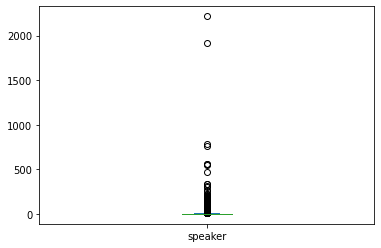

In [9]:
_ = speaker_freq[1:].plot(kind='box') # without None

#### Speaker occupations

In [1]:
# Helper functions
def speaker_to_occupation(qid):
    """Return the label associated with a qid or None if not available."""
    if qid in speaker_attribs.index:
        return speaker_attribs.occupation[qid]
    return None

def qid_to_label(qid):
    """Return the label associated with a qid or None if not available."""
    if qid in attrib_labels.index:
        return attrib_labels.Label[qid]
    return None
    
def map_list(fn, values):
    if values is not None:
        return list(map(fn, values))
    return []

def freq_count(vals, counts):
    if vals is None: return
    for val in vals:
        if val not in counts: counts[val] = 0
        counts[val] += 1

In [11]:
df_occupations = df.replace(to_replace='None', value=np.nan).dropna()
df_occupations["occupation"] = df_occupations.qids.apply(lambda val : speaker_to_occupation(val[0]))
df_occupations["occupation_labels"] = df_occupations.occupation.apply(lambda val : map_list(qid_to_label, val))

In [12]:
df_occupations.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,occupation,occupation_labels
0,2019-04-17-024782,"It is not a low-income immigration,",James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E,"[Q33999, Q10798782, Q3282637]","[actor, television actor, film producer]"
1,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E,"[Q49757, Q36180, Q6625963, Q11774202, Q214917,...","[poet, writer, novelist, essayist, playwright,..."
3,2019-10-31-056366,"It puts me in a predicament,",Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E,"[Q82955, Q40348]","[politician, lawyer]"
5,2019-08-15-002017,A Senator we can call our own.,Tom Rath,[Q7817334],2019-08-15 22:36:33,1,"[[Tom Rath, 0.7598], [None, 0.1993], [Warren R...",[http://www.nytimes.com/2019/08/15/us/politics...,E,[Q36180],[writer]
8,2019-07-22-032883,"It's a success, a relief and a technical feat,",Florence Parly,[Q3074013],2019-07-22 02:37:50,21,"[[Florence Parly, 0.9262], [None, 0.0738]]",[http://www.breitbart.com/news/french-submarin...,E,[Q82955],[politician]


In [61]:
occupation_stats = qb.where(qb.speaker_qid.isNotNull()) \
    .join(spk_attr.withColumnRenamed('id', 'speaker_qid'), on='speaker_qid') \
    .withColumn('profession', f.explode('occupation_labels')) \
    .groupby('profession') \
    .agg(f.count('quotation').alias('count')) \
    .sort('count', ascending=False).limit(10).toPandas()

Text(0, 0.5, 'Profession')

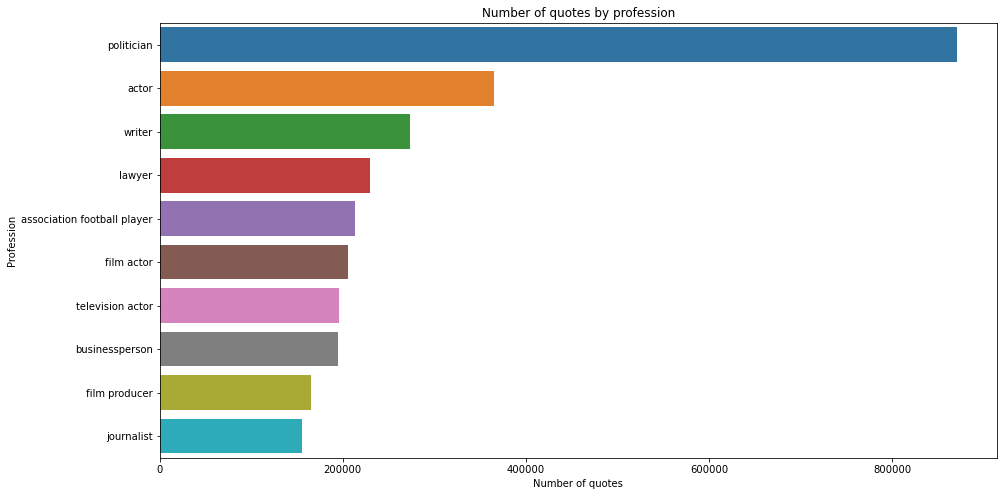

In [63]:
occupation_stats['profession_label'] = occupation_stats.profession.apply(lambda qid : labels.Label[qid])
plt.figure(figsize=(15,8))
sns.barplot(y='profession_label', x='count', data=occupation_stats)
plt.title("Number of quotes by profession")
plt.xlabel("Number of quotes")
plt.ylabel("Profession")

#### Speaker gender

#### Speaker age

### Exploring Media Sources
#### Top news domains with high profanity quotes

In [54]:
def profanity_by_news_outlet(df, min_quotes = 10000):
    return df \
        .withColumn('tld', f.explode('tlds')) \
        .groupby('tld') \
        .agg(f.avg('profanity').alias('avg_profanity'), f.count('quotation').alias('count')) \
        .where(f.col('count') >= min_quotes) \
        .sort('avg_profanity', ascending=False)

In [55]:
profanity_by_news_outlet(qb, 10000).show()

+------------------+-------------------+-----+
|               tld|      avg_profanity|count|
+------------------+-------------------+-----+
|               nme|0.12396075646092378|10657|
|thehollywoodgossip| 0.1010810278703445|12271|
|         inquisitr|0.09300202883093707|23046|
|           eonline|0.08896868517040082|11800|
|     thedailybeast|0.08871525342695481|13377|
|        cheatsheet|0.08829257405797264|29177|
|          etcanada|0.08813149158649779|10862|
|            thesun|0.08797538194233366|35166|
|        usmagazine|0.08560456494210512|13111|
|            people|0.08506631683579856|26263|
|              vice|0.08398846484226385|12531|
|       femalefirst|0.08353762173273721|13719|
|         wordpress|0.08251095076109365|21260|
|            mirror|0.08032704952593808|46170|
|         billboard|0.08022228466629261|15511|
|         dailystar|0.08013808967264716|29499|
|       irishmirror|0.07977294491611693|29566|
| hollywoodreporter|0.07638583168069987|11697|
|            

### Exploring Profanity

#### Compute profanity score for all quotes and add it to the dataframe as a feature

In [23]:
df['profanity'] = profanity_check.predict_prob(df['quotation']) 
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,len,profanity
0,2019-04-17-024782,"It is not a low-income immigration,",James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E,35,0.017196
1,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E,52,0.012897
2,2019-05-09-055187,It makes it much more difficult for him to mak...,None,[],2019-05-09 18:11:29,1,"[[None, 0.6493], [President Bill Clinton, 0.27...",[http://mobile.nytimes.com/2019/05/09/world/as...,E,71,0.025312
3,2019-10-31-056366,"It puts me in a predicament,",Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E,28,0.046677
4,2019-01-04-001792,A Pile of Leaves.,None,[],2019-01-04 10:00:07,1,"[[None, 0.8737], [Jason Fulford, 0.1263]]",[https://www.nytimes.com/2019/01/04/books/revi...,E,17,0.125558


#### Visualize profanity score distribution

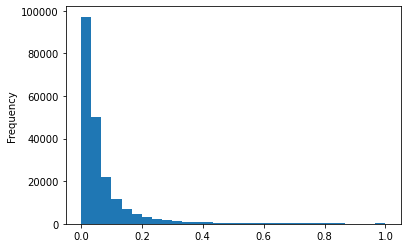

In [24]:
_ = df['profanity'].plot(kind='hist', bins=30, xlabel='profanity')

count    207527.000000
mean          0.071493
std           0.109267
min           0.000230
25%           0.017624
50%           0.036600
75%           0.076663
max           1.000000
Name: profanity, dtype: float64

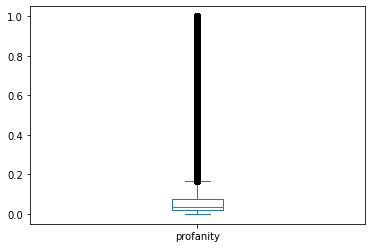

In [25]:
_ = df['profanity'].plot(kind='box')
df['profanity'].describe()

#### Distribution of quotations with higher profanity

In [26]:
# The following threshold is key for filtering out the most profane quotations
# Its final value still remains uncertain
threshold = 0.7
df_profane = df[df['profanity'] > threshold]
print(f"{len(df_profane)} quotes with profanity score > {threshold}")
df_profane.head()

1389 quotes with profanity score > 0.7


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,len,profanity
172,2019-01-10-120671,"You can put perfume on a pile of dung, and it ...",None,[],2019-01-10 00:54:59,2,"[[None, 0.876], [Michael Harrison, 0.0715], [M...",[http://www.nytimes.com/2019/01/09/us/baltimor...,E,144,0.747473
232,2019-09-21-039668,"Tell her to keep her mouth shut,",President Barack Obama,[Q76],2019-09-21 09:00:11,2,"[[President Barack Obama, 0.6097], [David Axel...",[http://www.nytimes.com/2019/09/21/us/politics...,E,32,0.975267
275,2019-07-05-076464,"We wanted to blow all that up,",Steven Wilson,[Q352766],2019-07-05 19:00:56,4,"[[Steven Wilson, 0.7926], [None, 0.2074]]",[http://mobile.nytimes.com/2019/07/05/nyregion...,E,30,0.743172
355,2019-09-19-033144,I find myself more concerned about the terribl...,None,[],2019-09-19 14:11:58,1,"[[None, 0.918], [President Trump, 0.082]]",[https://www.nytimes.com/2019/09/19/style/patt...,E,210,0.745001
362,2019-06-27-034157,"I think he was a racist,",Gabriel Sherman,[Q16210395],2019-06-27 18:00:46,1,"[[Gabriel Sherman, 0.8783], [None, 0.1044], [R...",[https://www.nytimes.com/2019/06/27/arts/telev...,E,24,0.813794


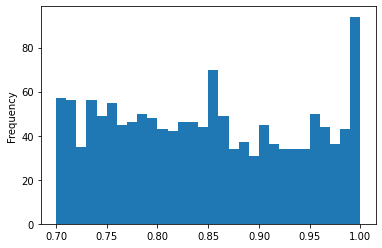

In [27]:
_ = df_profane['profanity'].plot(kind='hist', bins=30)

In [36]:
# Quote most common with highest profanity 
df_profane.iloc[df_profane['numOccurrences'].argmax()]

quoteID                                           2019-07-24-011721
quotation                disgusting, rat, and rodent infested mess.
speaker                                      President Donald Trump
qids                                                       [Q22686]
date                                            2019-07-24 21:11:30
numOccurrences                                                 3119
probas            [[President Donald Trump, 0.4486], [None, 0.22...
urls              [https://www.mitchellrepublic.com/news/nation/...
phase                                                             E
len                                                              42
profanity                                                  0.931411
Name: 186166, dtype: object

In [37]:
# Quote with highest profanity
df.loc[df['profanity'].argmax()] # Highest profanity quote

quoteID                                           2019-06-21-021744
quotation                                         Fuck you, Sparky.
speaker                                                        None
qids                                                             []
date                                            2019-06-21 14:57:07
numOccurrences                                                    3
probas            [[None, 0.5406], [Jeremy Denk, 0.3325], [Errol...
urls              [http://www.nytimes.com/interactive/2019/06/21...
phase                                                             E
len                                                              17
profanity                                                       1.0
Name: 37622, dtype: object

#### Most frequent words in high profanity quotations

In [43]:
words = df_profane.quotation.str.split(expand=True).stack()
filtered_words = pd.Series(filter(lambda word: word.lower() not in stopwords.words(), words))

In [44]:
filtered_words.value_counts().head(20)

I'm       99
like      99
going     73
--        63
kill      63
people    61
get       56
stupid    52
would     49
hate      48
hell      46
think     43
gay       39
like,     38
know      38
shut      36
black     35
got       34
white     33
racist    33
dtype: int64

#### Speaker frequency in high profanity quotations

In [28]:
df_profane['speaker'].value_counts().head(15)

None                      570
President Donald Trump     37
President Trump            23
Joe Biden                  16
Elizabeth Warren            8
JIMMY KIMMEL                7
Bernie Sanders              6
Pete Buttigieg              5
Lindsey Graham              5
Kirsten Gillibrand          5
Javier Marías               4
Saeed Jones                 3
Bill de Blasio              3
STEPHEN COLBERT             3
Rodrigo Duterte             3
Name: speaker, dtype: int64

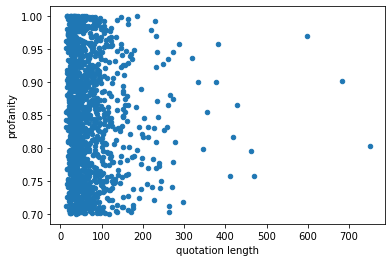

In [29]:
_ = df_profane.plot(kind='scatter', x='len', y='profanity', xlabel='quotation length') # No visible correlation

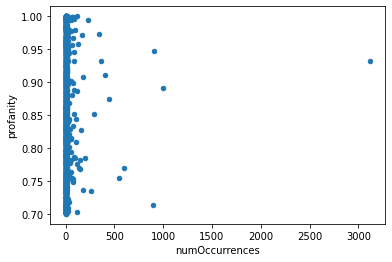

In [35]:
_ = df_profane.plot(kind='scatter', x='numOccurrences', y='profanity')

#### Most profane speakers

In [38]:
df.groupby('speaker')['profanity'].mean().sort_values(ascending=False).head(10)

speaker
Lee Martin           0.993907
Kristin Cavallari    0.983488
Scott Alexander      0.970337
Elizabeth Levy       0.951503
Cady Huffman         0.943276
Nic Pizzolatto       0.940754
Ed Dwight            0.928452
Joshua Rush          0.923477
William Buckley      0.922743
Will Young           0.918782
Name: profanity, dtype: float64

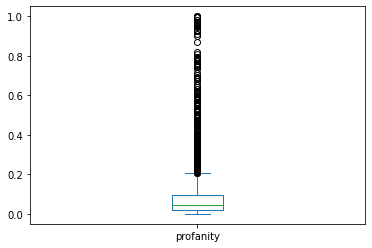

In [39]:
df_trump = df[df['speaker'] == ('President Donald Trump' or 'Donald Trump' or 'President Trump')]
_ = df_trump['profanity'].plot(kind='box') # Trump profanity distribution

#### Profanity by occupations

In [55]:
# Helper
def append_to_list(occupations, profanity, counts):
    if occupations is None: return
    for occupation in occupations:
        if occupation not in counts: counts[occupation] = []
        counts[occupation].append(profanity)

In [56]:
occupation_to_profanity_list = {}
df_occupations['profanity'] = profanity_check.predict_prob(df_occupations['quotation']) # Add profanity feature
_ = df_occupations.apply(lambda row: append_to_list(row['occupation_labels'], row['profanity'], occupation_to_profanity_list), axis=1)

In [57]:
occupation_to_profanity = {k: np.mean(v) for k, v in occupation_to_profanity_list.items()}

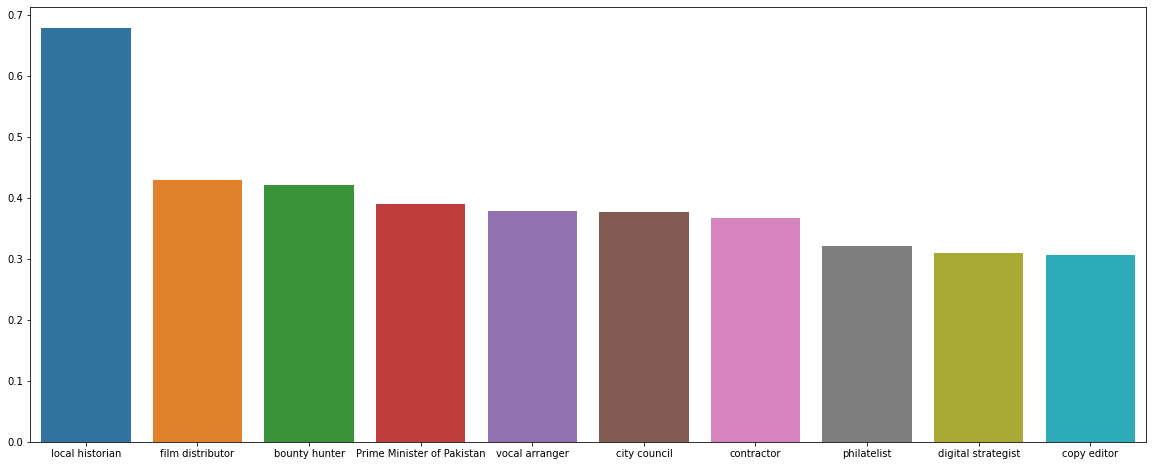

In [48]:
top10_by_profanity = sorted(occupation_to_profanity.items(), key=lambda x: x[1], reverse=True)[:10]
plt.figure(figsize=(20,8))
_ = sns.barplot(x=[x for x,y in top10_by_profanity], y=[y for x,y in top10_by_profanity])

#### Profanity by age

#### Profanity by gender

## Temporal Analysis

In [64]:
# Extract the yyyy-mm part from the date
@f.udf(StringType())
def get_month(date_str):
    return "-".join(date_str.split("-")[:2])

@f.udf(StringType())
def get_date(date_str):
    return "-".join(date_str.split("-")[:3])

def normalize(key, pdf):
    return pd.DataFrame({"key": [ key[0] ], "mean" : [ pdf.profanity.mean() ], "sem" : [ pdf.profanity.sem() ]})

def plot_distribution(df, title):
    plt.figure(figsize=(6,8))
    plt.ylim(0.99 * df['mean'].min(), 1.01 * df['mean'].max())
    sns.barplot(x=df["key"], y=df["mean"], yerr=1.96*df["sem"])
    plt.xlabel("month")
    plt.ylabel("average profanity with 95% error bars")
    plt.title(title)
    plt.show()

#### Moving average of profanities

In [49]:
daily_avg = qb \
        .withColumn('date', get_date(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

In [52]:
daily_avg = daily_avg.set_index('key')
mavg = daily_avg.rolling(14).mean()

/usr/local/anaconda3/envs/ada/lib/python3.8/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


<AxesSubplot:xlabel='key'>

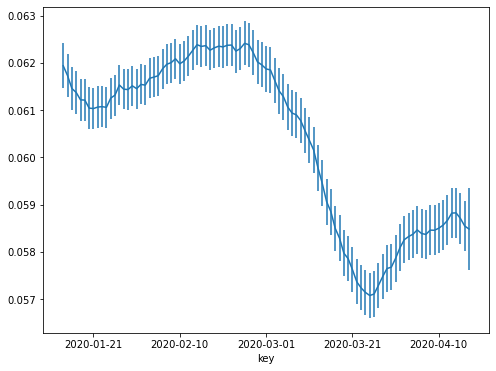

In [58]:
plt.figure(figsize=(8, 6))
mavg['mean'].plot.line(yerr=mavg['sem'])

#### Monthly average profanity

In [67]:
d1 = qb.where(qb.speaker_qid.isNotNull()) \
        .withColumn('date', get_month(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

In [68]:
d2 = qb.where(qb.speaker_qid.isNotNull()) \
        .withColumn('date', get_month(f.col('quoteID'))) \
        .where( (qb.speaker != "President Donald Trump") \
               & (qb.speaker != "President Trump") \
               & (qb.speaker != "Donald Trump") ) \
        .groupby("date") \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

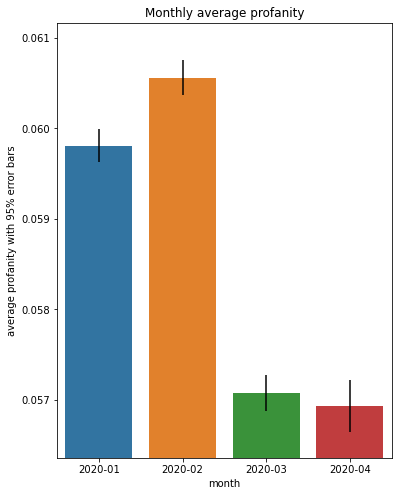

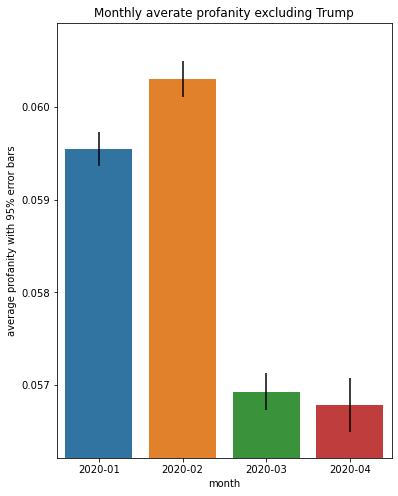

In [69]:
plot_distribution(d1, "Monthly average profanity")
plot_distribution(d2, "Monthly averate profanity excluding Trump")

(0.05621509567879076, 0.06116344827488733)

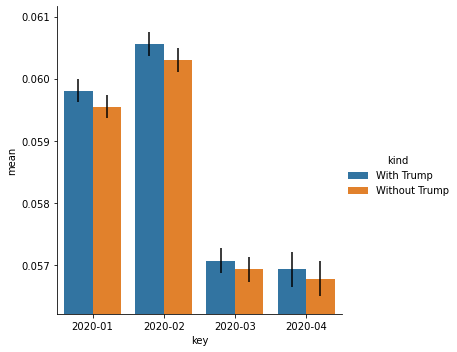

In [70]:
d1['kind'] = 'With Trump'
d2['kind'] = 'Without Trump'
d = pd.concat([d1, d2])
sns.catplot(x='key', y='mean', hue='kind', data=d, kind='bar', yerr=1.96 * d1['sem'])
plt.ylim(0.99 * d['mean'].min(), 1.01 * d['mean'].max())